In [ ]:
# Standard library imports
from datetime import time, datetime, timedelta
import os

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample
from tqdm import tqdm
from joblib import Parallel, delayed

# Local imports
from helper_code import *
from team_code import *
from segment_quality_evaluation import process_EEG

# autoreload changes in helper_code and team_code
%load_ext autoreload
%autoreload 2


# Get the start time (as a time object) from the recording data.
def get_start_time_triplet(string):
    variable = get_variable(string, '#Start time', str)
    hours, minutes, seconds = (int(value) for value in variable.split(':'))
    return time(hours, minutes, seconds)

# Get the end time (as a time object) from the recording data.
def get_end_time_triplet(string):
    variable = get_variable(string, '#End time', str)
    hours, minutes, seconds = (int(value) for value in variable.split(':'))
    return time(hours, minutes, seconds)

DATA_FOLDER = "../data/"
ROOT_FOLDER = DATA_FOLDER+ "physionet.org/files/i-care/2.1/training"

In [ ]:
1

1

In [ ]:
def segmentos_5_minutos(start: time, end: time):
    # Convertir a datetime para facilitar los cálculos
    start_dt = datetime(2000, 1, 1, start.hour, start.minute, start.second)
    end_dt = datetime(2000, 1, 1, end.hour, end.minute, end.second)
    
    # Ajustar el inicio al siguiente múltiplo de 5 minutos
    start_min = (start_dt.minute // 5) * 5
    if start_dt.minute % 5 != 0 or start_dt.second > 0:
        start_min += 5
    
    # Controlar si start_min se vuelve 60 y ajustar la hora
    if start_min == 60:
        start_segment = datetime(2000, 1, 1, start_dt.hour + 1, 0, 0)
    else:
        start_segment = datetime(2000, 1, 1, start_dt.hour, start_min, 0)
    
    # Lista de segmentos
    segments = []
    
    while start_segment + timedelta(minutes=5) - timedelta(seconds=1) <= end_dt:
        end_minute = start_segment.minute + 4
        end_hour = start_segment.hour
        if end_minute >= 60:
            end_minute -= 60
            end_hour += 1
        
        segments.append((
            time(start_segment.hour, start_segment.minute, 0),
            time(end_hour, end_minute, 59)
        ))
        start_segment += timedelta(minutes=5)
    
    return segments

def dividir_dataframe_en_segmentos(df, start: time, end: time, sampling_frequency: int):
    samples_per_5_min = sampling_frequency * 5 * 60
    start_times = []
    end_times = []

    # If len is less that 5min do early return
    if len(df) < samples_per_5_min:
        return start_times, end_times

    segments = segmentos_5_minutos(start, end)

    return segments

In [ ]:
# Definir los tiempos de inicio y fin
start_time = time(23, 00, 0)
end_time = time(23, 59, 59)

# Crear un DataFrame de ejemplo con sampling_frequency de 128
sampling_frequency = 128  # 128 observaciones por segundo
total_seconds = (datetime(2000, 1, 1, end_time.hour, end_time.minute, end_time.second) - 
                 datetime(2000, 1, 1, start_time.hour, start_time.minute, start_time.second)).total_seconds()
data = {"col1": range(int(total_seconds * sampling_frequency)), "col2": range(int(total_seconds * sampling_frequency))}
df = pd.DataFrame(data)

# Obtener sub DataFrames
segments = dividir_dataframe_en_segmentos(df, start_time, end_time, sampling_frequency)

# Imprimir cada sub DataFrame
for i, (start_frag, end_frag) in enumerate(segments):
    print(f"Segmento {i + 1} (Inicio: {start_frag}, Fin: {end_frag}):")

Segmento 1 (Inicio: 23:00:00, Fin: 23:04:59):
Segmento 2 (Inicio: 23:05:00, Fin: 23:09:59):
Segmento 3 (Inicio: 23:10:00, Fin: 23:14:59):
Segmento 4 (Inicio: 23:15:00, Fin: 23:19:59):
Segmento 5 (Inicio: 23:20:00, Fin: 23:24:59):
Segmento 6 (Inicio: 23:25:00, Fin: 23:29:59):
Segmento 7 (Inicio: 23:30:00, Fin: 23:34:59):
Segmento 8 (Inicio: 23:35:00, Fin: 23:39:59):
Segmento 9 (Inicio: 23:40:00, Fin: 23:44:59):
Segmento 10 (Inicio: 23:45:00, Fin: 23:49:59):
Segmento 11 (Inicio: 23:50:00, Fin: 23:54:59):
Segmento 12 (Inicio: 23:55:00, Fin: 23:59:59):


In [5]:
data_folder = ROOT_FOLDER
patient_ids = find_data_folders(data_folder)
num_patients = len(patient_ids)
current_features = None
GROUP = 'EEG'



def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second

def resample_segment(data, original_sampling_frequency, target_sampling_frequency):
    num_samples = int(data.shape[1] * target_sampling_frequency / original_sampling_frequency)
    resampled_data = resample(data, num_samples, axis=1)
    return resampled_data

In [6]:
N_HOURS = 12

MIN_MINUTES = 5
DROP_MEAN_STD = 0
DOUBLE_BANANA = [
        ("Fp1", "F7"), ("F7", "T3"), ("T3", "T5"), ("T5", "O1"),  # Left temporal chain
        ("Fp2", "F8"), ("F8", "T4"), ("T4", "T6"), ("T6", "O2"),  # Right temporal chain
        ("Fp1", "F3"), ("F3", "C3"), ("C3", "P3"), ("P3", "O1"),  # Left parasagittal chain
        ("Fp2", "F4"), ("F4", "C4"), ("C4", "P4"), ("P4", "O2"),  # Right parasagittal chain
        ("Fz", "Cz"), ("Cz", "Pz")                                # Central chain
]
BANDPASS_FREQS = [0.1, 45.0]
TARGET_SAMPLING_FREQUENCY = 128 # Nyquist

In [7]:
len(DOUBLE_BANANA)

18

## FMM features

In [ ]:
# Define a function to process a single recording file
def process_recording(patient_id, recording_id):
    try:
        recording_location = os.path.join(
            data_folder, patient_id, f"{recording_id}_{GROUP}"
        )

        with open(recording_location + ".hea", "r") as f:
            header = f.read()
            start_time = get_start_time_triplet(header)
            end_time = get_end_time_triplet(header)

        data, channels, sampling_frequency = load_recording_data(recording_location)
        utility_frequency = get_utility_frequency(recording_location + ".hea")
        data, sampling_frequency = preprocess_data(
            data, sampling_frequency, utility_frequency, channels
        )

        if data is None:
            return None  # Skip empty data

        data = get_bipolar_data(data)  # Create double-banana montage
        segments = dividir_dataframe_en_segmentos(
            data, start_time, end_time, sampling_frequency
        )

        segment_results = []  # Store segment results for this file

        for start_frag, end_frag in segments:
            start_idx = (
                time_to_seconds(start_frag) - time_to_seconds(start_time)
            ) * sampling_frequency
            end_idx = (
                time_to_seconds(end_frag) - time_to_seconds(start_time)
            ) * sampling_frequency + sampling_frequency
            segment_df = data.iloc[start_idx:end_idx, :].reset_index(drop=True)


            seg_masks_df = process_EEG(
                segment_df,
                sampling_frequency,
                patient_id,
                start_frag,
                end_frag,
            )
            segment_results.append(seg_masks_df)

        return pd.concat(segment_results, axis=0) if segment_results else None

    except Exception as e:
        print(f"Error processing recording {recording_id} for patient {patient_id}: {e}")
        return None

# Process each patient separately and save their results immediately
for patient_id in tqdm(patient_ids, desc="Processing Patients"):
    # Process all files of a single patient in parallel
    num_jobs = 10 # Use all CPU cores
    patient_results = Parallel(n_jobs=num_jobs)(
        delayed(process_recording)(patient_id, recording_id)
        for recording_id in find_recording_files(data_folder, patient_id)
    )

    # Remove None results
    patient_results = [res for res in patient_results if res is not None]

    if patient_results:
        segment_quality_df = pd.concat(patient_results, axis=0)
        output_dir = os.path.join(DATA_FOLDER, "quality")
        os.makedirs(output_dir, exist_ok=True)
        csv_path = os.path.join(output_dir, f"{patient_id}_segment_quality.csv")

        # Save CSV immediately per patient
        segment_quality_df.to_csv(csv_path, index=False)
        print(f"Saved: {csv_path}")


(73954, 9)


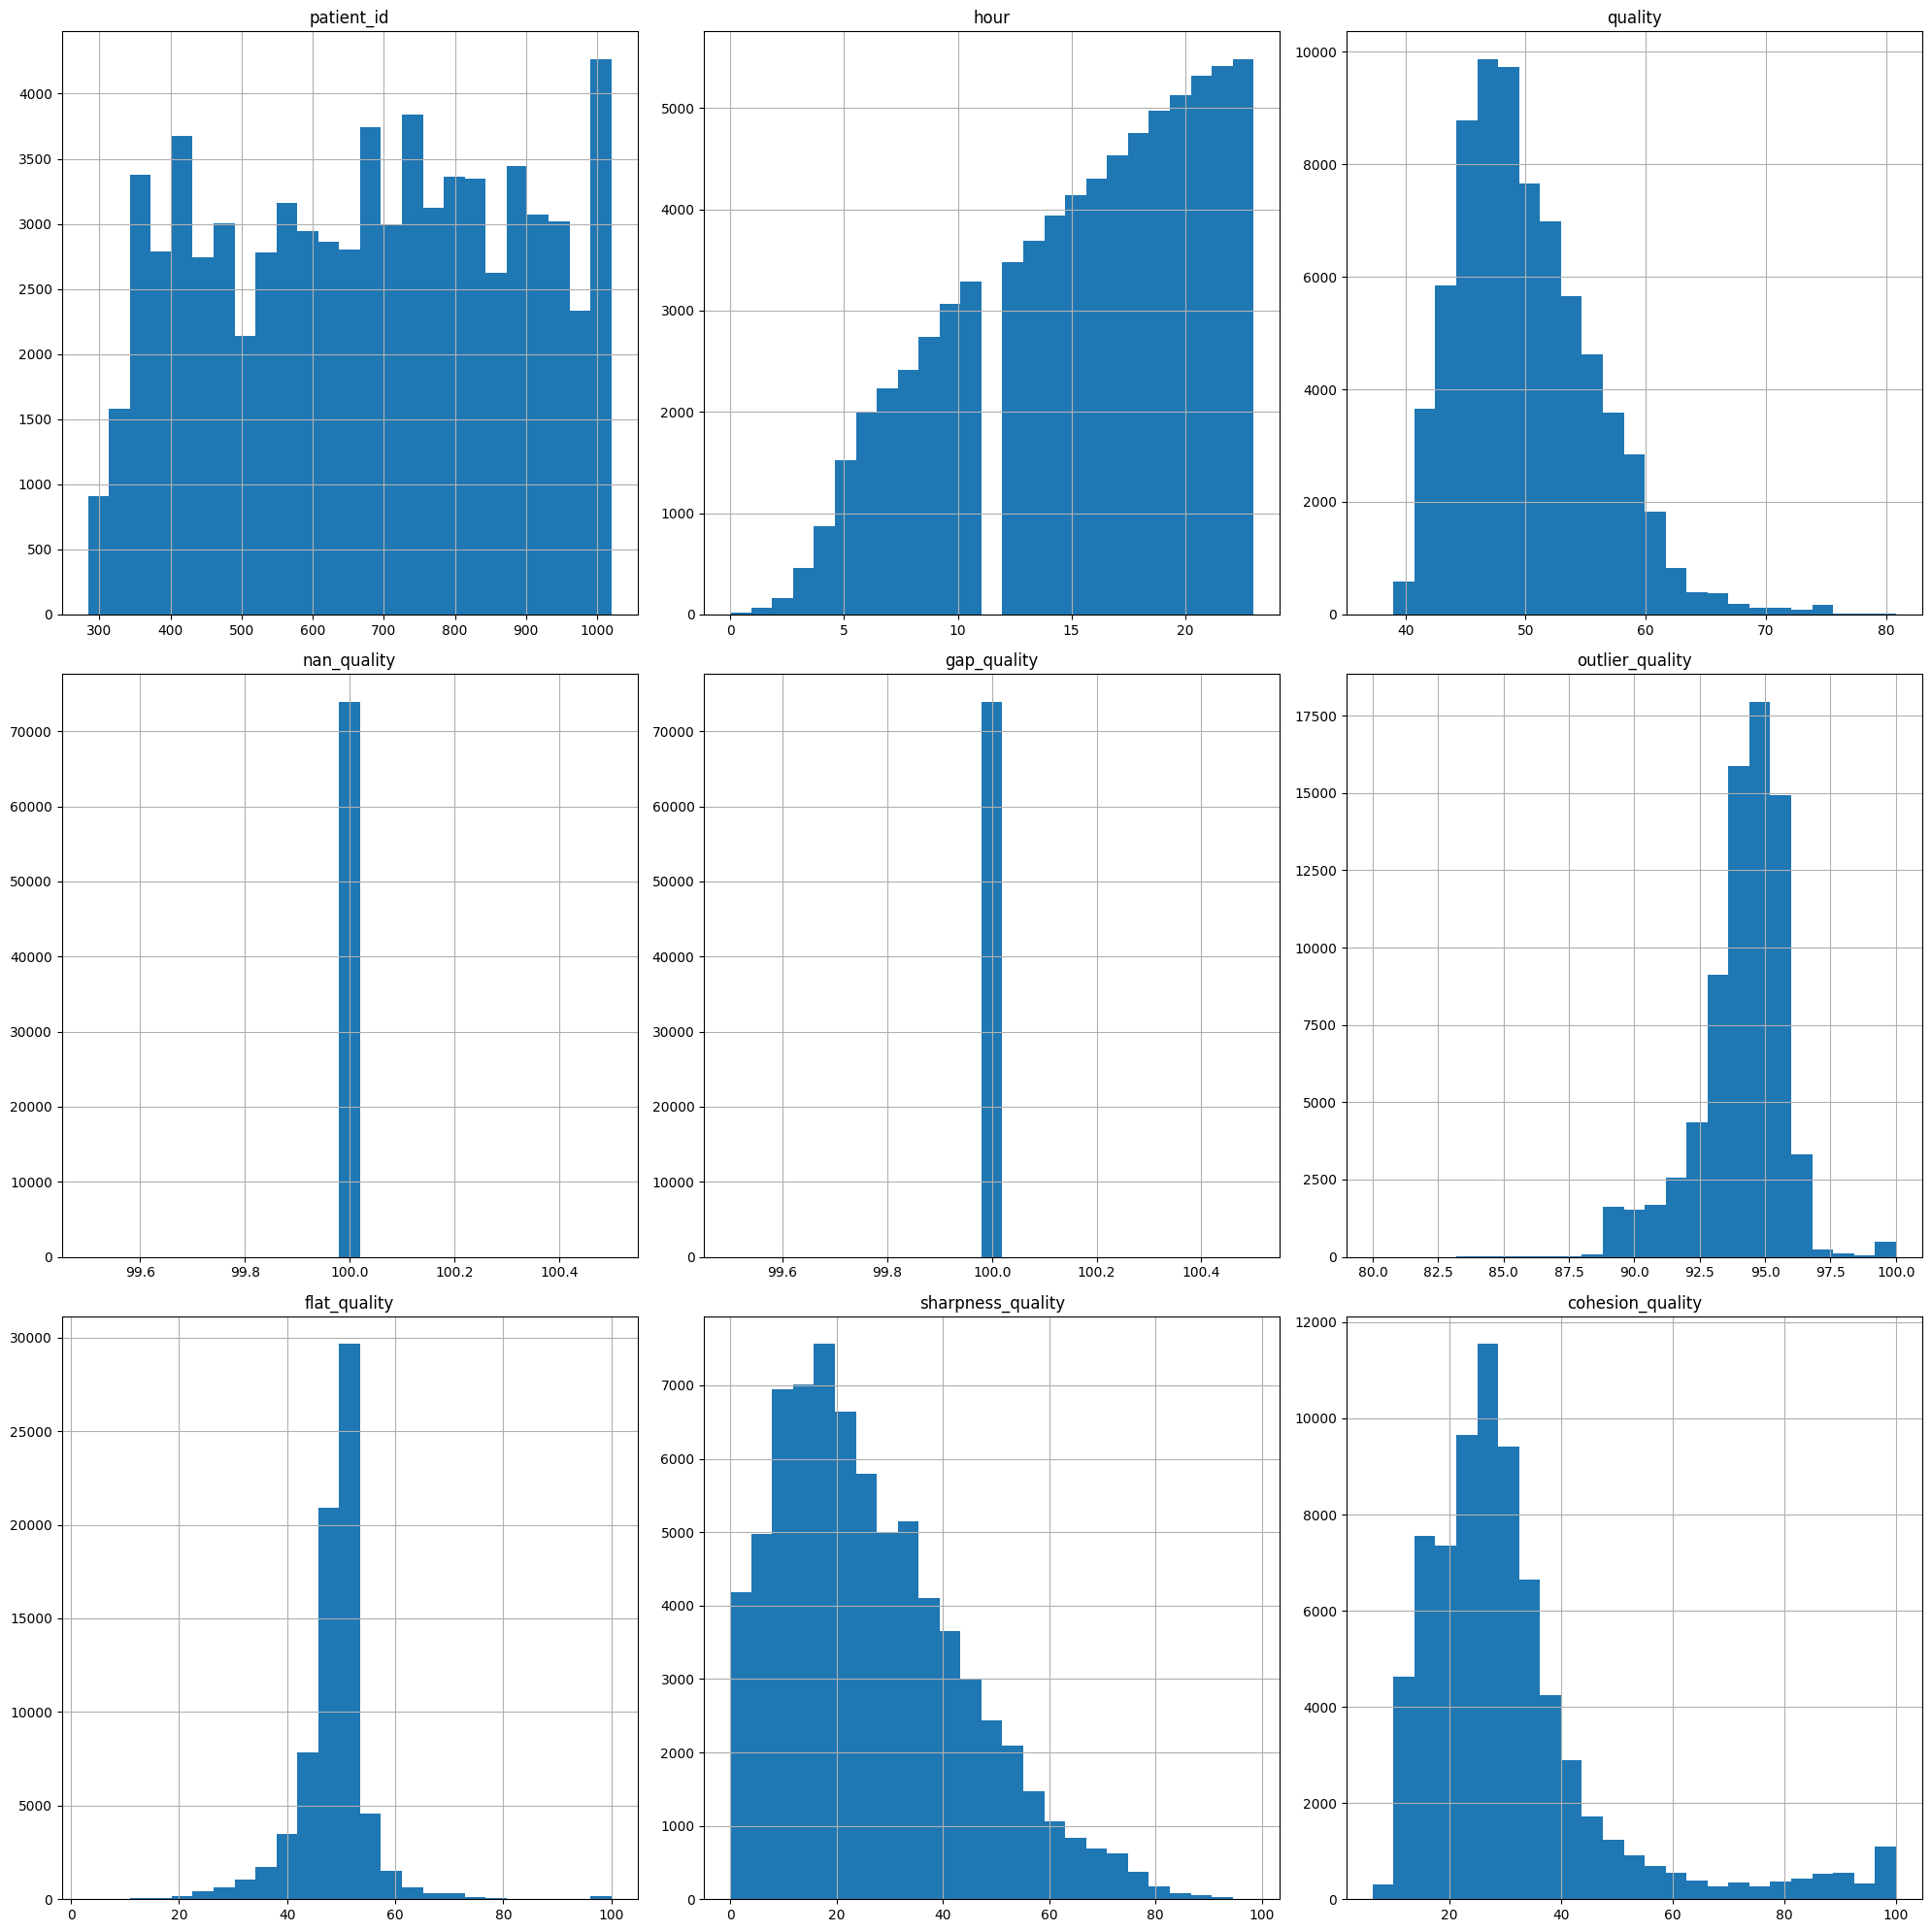

In [8]:
# read all excel files in the folder and concatenate them into a single dataframe
quality_folder = os.path.join(DATA_FOLDER, "quality")
quality_files = [f for f in os.listdir(quality_folder) if f.endswith(".csv")]
quality_dfs = [pd.read_csv(os.path.join(quality_folder, f)) for f in quality_files]
quality_df = pd.concat(quality_dfs, axis=0)
print(quality_df.shape)
quality_df.insert(1, "hour", quality_df["start_time"].apply(lambda x: int(x.split(":")[0])))
quality_df.insert(2, "time_block", quality_df["hour"].floordiv(4).apply(lambda x: f"{x*4}-{(x+1)*4}H"))


quality = quality_df.iloc[:, -4:].mean(axis=1)
quality_df.insert(4, "quality", quality)
quality_df = quality_df.sort_values(by=["patient_id", "start_time"], ascending=True)
quality_df.head()
# plot the distribution of each quality metric
quality_df.hist(figsize=(20, 20), bins=25)
plt.tight_layout()
plt.show()

In [ ]:
np.random.seed(42)  # For reproducibility


def get_random(group):
    return group.sample(1)


def get_central(group):
    n = len(group)
    idx = group.iloc[
        [(n - 1) // 2]
    ]  # group.iloc[[n // 2]] if n % 2 == 1 else group.iloc[[(n - 1) // 2]]
    return idx


def get_last_above_threshold(group, threshold=50):
    filtered = group[group["quality"] >= threshold]
    if filtered.empty:
        return pd.DataFrame()
    return filtered.iloc[[-1]]


def get_last(group):
    return group.iloc[[-1]]


grouped = quality_df.groupby(["patient_id", "time_block"], group_keys=False)

max_quality = grouped.apply(lambda g: g.loc[[g["quality"].idxmax()]])
min_quality = grouped.apply(lambda g: g.loc[[g["quality"].idxmin()]])
random_quality = grouped.apply(get_random)
central = grouped.apply(get_central)
last = grouped.apply(get_last)
lastgood = grouped.apply(get_last_above_threshold, threshold=50)

max_quality["maxQ"] = 1
min_quality["minQ"] = 1
random_quality["random"] = 1
central["central"] = 1
last["last"] = 1
lastgood["lastQ50+"] = 1


epoch_subset = pd.concat(
    [max_quality, min_quality, random_quality, central, last, lastgood]
).reset_index(drop=True)

print(epoch_subset.shape)

epoch_subset = epoch_subset.sort_values(["patient_id", "start_time"]).reset_index(
    drop=True
)
# epoch_subset = epoch_subset.drop_duplicates(subset=['patient_id', 'start_time'], keep='first')

epoch_subset = pd.merge(
    epoch_subset,
    quality_df[["patient_id", "start_time"]],
    on=["patient_id", "start_time"],
    how="right",
)

#epoch_subset = epoch_subset.fillna(0)
epoch_subset["all"] = 1
print(epoch_subset.shape)


epoch_subset["patient_id"] = epoch_subset["patient_id"].apply(lambda x: f"{x:04d}")
epoch_subset.to_csv(os.path.join(DATA_FOLDER, "epoch_subset.csv"), index=False)
epoch_subset.head()

C:\Users\Adolfo\AppData\Local\Temp\ipykernel_13556\471296005.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  max_quality = grouped.apply(lambda g: g.loc[[g["quality"].idxmax()]])
C:\Users\Adolfo\AppData\Local\Temp\ipykernel_13556\471296005.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_quality = grouped.apply(lambda g: g.loc[[g["quality"].idxmin()]])
C:\Users\Adolfo\AppData\Local\Temp\ipykern

(10569, 18)
(75534, 19)


,patient_id,hour,time_block,start_time,quality,end_time,nan_quality,gap_quality,outlier_quality,flat_quality,sharpness_quality,cohesion_quality,maxQ,minQ,random,middle,last,lastQ50+,all
0,0284,4.0,4-8H,04:10:00,57.375176,04:14:59,100.0,100.0,93.10489,47.725839,59.640442,29.029533,1.0,NaN,NaN,NaN,NaN,NaN,1
1,0284,NaN,NaN,04:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,0284,NaN,NaN,04:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,0284,NaN,NaN,04:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,0284,NaN,NaN,04:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [50]:
epoch_subset.describe()

,hour,quality,nan_quality,gap_quality,outlier_quality,flat_quality,sharpness_quality,cohesion_quality,maxQ,minQ,random,midTime,last,lastQ50+,all
count,10569.000000,10569.000000,10569.0,10569.0,10569.000000,10569.000000,10569.000000,10569.000000,10569.000000,10569.000000,10569.000000,10569.000000,10569.000000,10569.000000,10569.0
mean,15.200965,50.886783,100.0,100.0,94.024165,48.791466,28.592871,32.138632,0.173337,0.173337,0.173337,0.173337,0.173337,0.133314,1.0
std,5.744358,6.075010,0.0,0.0,1.791428,6.681294,19.005617,19.014669,0.378556,0.378556,0.378556,0.378556,0.378556,0.339930,0.0
min,0.000000,37.261385,100.0,100.0,83.333333,5.587384,0.000000,6.250031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,11.000000,46.255137,100.0,100.0,93.225260,47.005498,13.335417,20.097129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,16.000000,50.423279,100.0,100.0,94.293981,49.711661,25.647948,27.337667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,20.000000,54.691762,100.0,100.0,95.183738,51.128617,40.555888,36.339175,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
max,23.000000,80.812086,100.0,100.0,100.000000,100.000000,98.477246,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
